# Monte Carlo Grid Congestion Risk Simulation

This notebook extends the basic grid congestion simulation by applying Monte Carlo methods to analyze how different levels of electric vehicle (EV) and solar photovoltaic (PV) adoption affect transformer congestion risk.

Monte Carlo simulation allows us to account for uncertainty and variability in household electricity consumption patterns by running many simulations with different random inputs. This provides a more robust assessment of congestion probability under various technology adoption scenarios.

## Setup and Configuration

First, we'll import the necessary libraries and define our simulation parameters. The key parameters include:

- Number of houses connected to the transformer
- Transformer capacity in kilowatts (kW)
- EV charging power and typical charging hours
- Solar PV output capacity and generation hours
- Number of Monte Carlo simulations to run

In [19]:
# %%
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append('..')  # Add parent directory to path

# Import from src
from src.grid_model import generate_lv_grid
from src.simulate import generate_hourly_load_profiles_realistic
from src.visualize import compute_total_load

# Parameters
N_HOUSES = 50
HOURS = 24
TRANSFORMER_CAPACITY = 120  # kW
TRANSFORMER_ID = "TR_001"
DATA_DIR = "data/generated"
N_SIMULATIONS = 200

# EV and Solar PV parameters
EV_LOAD = 2.5  # kW
EV_HOURS = range(18, 23)  # 18:00-22:00

PV_MAX_OUTPUT = 2.0  # kW
PV_HOURS = range(10, 17)  # 10:00-16:00

# Create data directory if it doesn't exist
os.makedirs(DATA_DIR, exist_ok=True)

## Technology Impact Functions

These functions model how EVs and solar PV systems affect household electricity consumption. 

- EVs increase consumption during evening charging hours
- Solar PV reduces net consumption during daylight hours

In [20]:

def add_technologies(base_profiles, n_ev, n_pv):
    """Add EVs and solar panels to random houses"""
    profiles = base_profiles.copy()
    
    # Randomly select houses for each technology
    all_houses = profiles.index.tolist()
    ev_houses = np.random.choice(all_houses, size=min(n_ev, len(all_houses)), replace=False)
    pv_houses = np.random.choice(all_houses, size=min(n_pv, len(all_houses)), replace=False)
    
    # Add EV load
    for house in ev_houses:
        for hour in EV_HOURS:
            profiles.loc[house, f'hour_{hour}'] += EV_LOAD
    
    # Subtract PV generation
    for house in pv_houses:
        for hour in PV_HOURS:
            # Scale PV output based on time of day (peak at noon)
            hour_factor = 1.0 - 0.3 * abs(hour - 12) / 3  # Peak at hour 12
            pv_output = PV_MAX_OUTPUT * hour_factor
            
            # Ensure load doesn't go negative
            current_load = profiles.loc[house, f'hour_{hour}']
            profiles.loc[house, f'hour_{hour}'] = max(0.1, current_load - pv_output)
    
    return profiles

## Single Simulation Function

This function runs a single simulation for a given number of EVs and PVs. It:

1. Generates random household load profiles
2. Adds the effects of EVs and PVs
3. Calculates the total transformer load
4. Determines if congestion occurs (peak load > transformer capacity)

In [21]:

def run_single_simulation(n_ev, n_pv):
    """Run a single simulation with given number of EVs and PVs"""
    # Generate synthetic grid
    G = generate_lv_grid(N_HOUSES)
    
    # Generate synthetic hourly load profiles
    house_ids = list(G.nodes())
    load_profiles = generate_hourly_load_profiles_realistic(house_ids)
    
    # Add technologies
    modified_profiles = add_technologies(load_profiles, n_ev, n_pv)
    
    # Calculate total load
    total_load = compute_total_load(modified_profiles)
    
    # Check for congestion
    peak_load = total_load.max()
    congestion = peak_load > TRANSFORMER_CAPACITY
    
    return {
        'peak_load': peak_load,
        'congestion': congestion,
        'total_load': total_load
    }

## Monte Carlo Simulation Function

This function runs multiple simulations for each combination of EV and PV adoption levels. It calculates the probability of congestion and average peak load for each scenario.

In [22]:

def run_monte_carlo_simulations():
    """Run Monte Carlo simulations for different EV and PV adoption levels"""
    results = []
    
    # Define EV and PV adoption levels to test
    ev_levels = range(0, 11, 2) 
    pv_levels = range(0, 11, 2)  
        
    # Run simulations for each combination
    for n_ev in ev_levels:
        for n_pv in pv_levels:
            print(f"Running simulations for {n_ev} EVs and {n_pv} PVs...")
            
            # Run multiple simulations
            congestion_count = 0
            peak_loads = []
            
            for i in range(N_SIMULATIONS):
                sim_result = run_single_simulation(n_ev, n_pv)
                
                if sim_result['congestion']:
                    congestion_count += 1
                    
                peak_loads.append(sim_result['peak_load'])
                
                # Save the first simulation's load profile for visualization
                if i == 0:
                    example_load = sim_result['total_load']
            
            # Calculate congestion probability and average peak load
            congestion_probability = congestion_count / N_SIMULATIONS
            avg_peak_load = sum(peak_loads) / len(peak_loads)
            
            # Store results
            results.append({
                'n_ev': n_ev,
                'n_pv': n_pv,
                'congestion_probability': congestion_probability,
                'avg_peak_load': avg_peak_load,
                'example_load': example_load
            })
    
    return pd.DataFrame(results)

## Run the Monte Carlo Simulation

Now we'll run the full Monte Carlo simulation and save the results. This may take some time to complete as it runs hundreds of simulations.

In [23]:
results = run_monte_carlo_simulations()

# Save results to CSV
results.to_csv(f"{DATA_DIR}/monte_carlo_results.csv", index=False)
print(f"Saved results to {DATA_DIR}/monte_carlo_results.csv")

# Display summary
print("\nSummary of results:")
print(results[['n_ev', 'n_pv', 'congestion_probability', 'avg_peak_load']])

Running simulations for 0 EVs and 0 PVs...
Running simulations for 0 EVs and 2 PVs...
Running simulations for 0 EVs and 4 PVs...
Running simulations for 0 EVs and 6 PVs...
Running simulations for 0 EVs and 8 PVs...
Running simulations for 0 EVs and 10 PVs...
Running simulations for 2 EVs and 0 PVs...
Running simulations for 2 EVs and 2 PVs...
Running simulations for 2 EVs and 4 PVs...
Running simulations for 2 EVs and 6 PVs...
Running simulations for 2 EVs and 8 PVs...
Running simulations for 2 EVs and 10 PVs...
Running simulations for 4 EVs and 0 PVs...
Running simulations for 4 EVs and 2 PVs...
Running simulations for 4 EVs and 4 PVs...
Running simulations for 4 EVs and 6 PVs...
Running simulations for 4 EVs and 8 PVs...
Running simulations for 4 EVs and 10 PVs...
Running simulations for 6 EVs and 0 PVs...
Running simulations for 6 EVs and 2 PVs...
Running simulations for 6 EVs and 4 PVs...
Running simulations for 6 EVs and 6 PVs...
Running simulations for 6 EVs and 8 PVs...
Running 

## Visualize Example Load Profiles

Let's visualize some example load profiles to understand how EVs and PVs affect the transformer load.

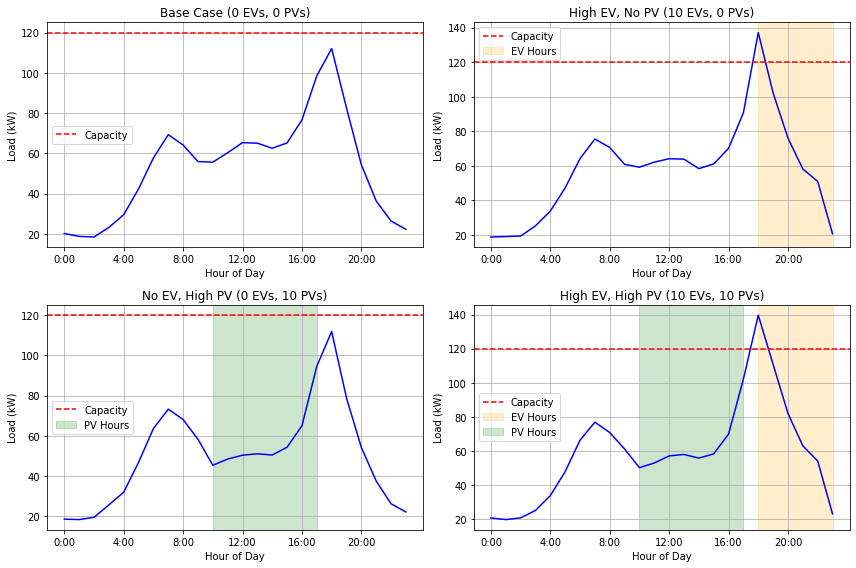

In [15]:
plt.figure(figsize=(12, 8))

# Get example scenarios
scenarios = [
    (0, 0, 'Base Case'),
    (10, 0, 'High EV, No PV'),
    (0, 10, 'No EV, High PV'),
    (10, 10, 'High EV, High PV')
]

for i, (n_ev, n_pv, label) in enumerate(scenarios):
    scenario = results[(results['n_ev'] == n_ev) & (results['n_pv'] == n_pv)].iloc[0]
    
    plt.subplot(2, 2, i+1)
    plt.plot(range(HOURS), scenario['example_load'], 'b-')
    plt.axhline(TRANSFORMER_CAPACITY, color='r', linestyle='--', label='Capacity')
    
    # Highlight EV and PV hours
    if n_ev > 0:
        plt.axvspan(min(EV_HOURS), max(EV_HOURS)+1, alpha=0.2, color='orange', label='EV Hours')
    if n_pv > 0:
        plt.axvspan(min(PV_HOURS), max(PV_HOURS)+1, alpha=0.2, color='green', label='PV Hours')
    
    plt.title(f'{label} ({n_ev} EVs, {n_pv} PVs)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Load (kW)')
    plt.xticks(range(0, HOURS, 4), [f'{h}:00' for h in range(0, HOURS, 4)])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/example_load_profiles.png")
plt.show()

## Visualize Congestion Probability

Now we'll create visualizations to understand how EV and PV adoption affects congestion probability.

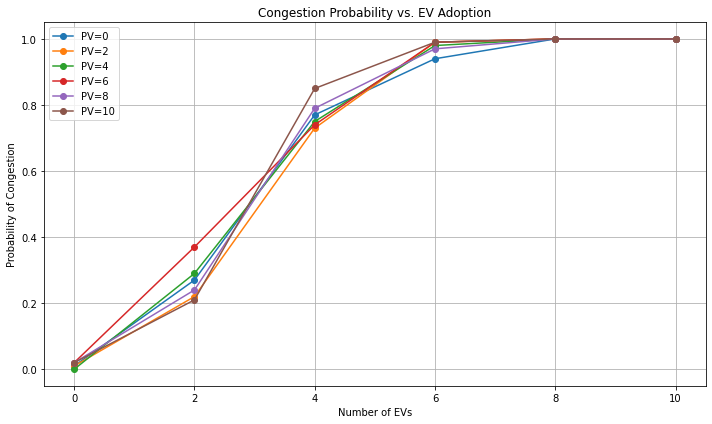

In [16]:
# Plot congestion probability vs EV adoption (for different PV levels)
plt.figure(figsize=(10, 6))

for n_pv in sorted(results['n_pv'].unique()):
    subset = results[results['n_pv'] == n_pv]
    plt.plot(subset['n_ev'], subset['congestion_probability'], 
             marker='o', label=f'PV={n_pv}')

plt.title('Congestion Probability vs. EV Adoption')
plt.xlabel('Number of EVs')
plt.ylabel('Probability of Congestion')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/congestion_vs_ev.png")
plt.show()

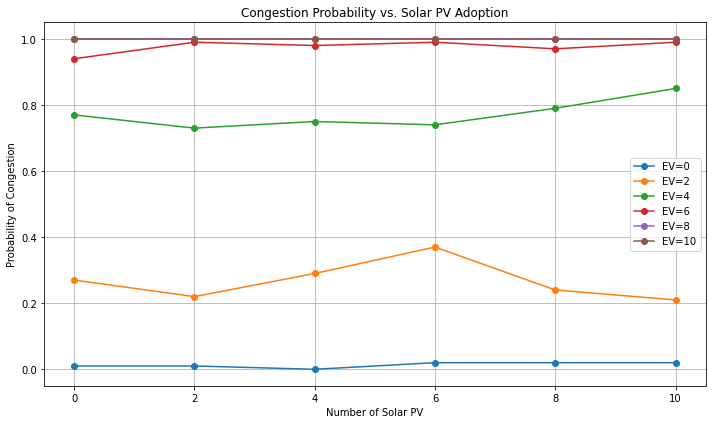

In [17]:
# Plot congestion probability vs PV adoption (for different EV levels)
plt.figure(figsize=(10, 6))

for n_ev in sorted(results['n_ev'].unique()):
    subset = results[results['n_ev'] == n_ev]
    plt.plot(subset['n_pv'], subset['congestion_probability'], 
             marker='o', label=f'EV={n_ev}')

plt.title('Congestion Probability vs. Solar PV Adoption')
plt.xlabel('Number of Solar PV')
plt.ylabel('Probability of Congestion')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"{DATA_DIR}/congestion_vs_pv.png")
plt.show()

## Create Heatmap Visualizations

Finally, we'll create heatmaps to visualize congestion probability and peak load across all EV and PV combinations.

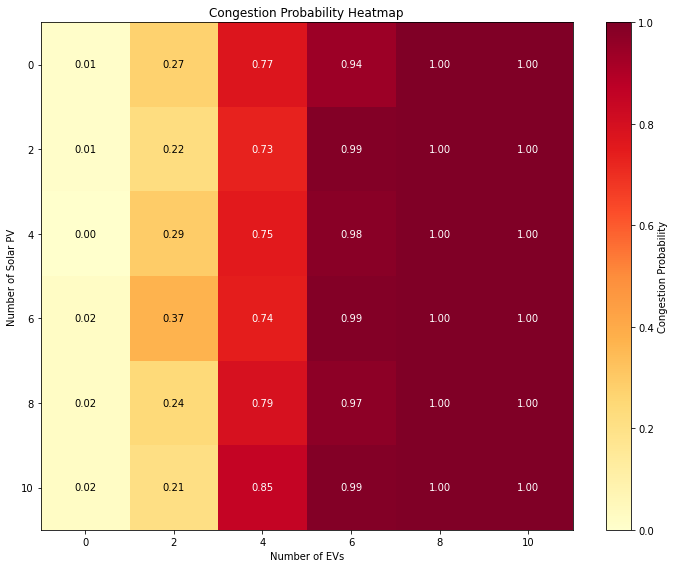

In [18]:
# Create a heatmap of congestion probability (EV vs PV)
pivot_table = results.pivot(index='n_pv', columns='n_ev', values='congestion_probability')

plt.figure(figsize=(10, 8))
plt.imshow(pivot_table, cmap='YlOrRd', interpolation='nearest', aspect='auto')
plt.colorbar(label='Congestion Probability')
plt.title('Congestion Probability Heatmap')
plt.xlabel('Number of EVs')
plt.ylabel('Number of Solar PV')
plt.xticks(range(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(range(len(pivot_table.index)), pivot_table.index)

# Add text annotations
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        plt.text(j, i, f'{pivot_table.iloc[i, j]:.2f}', 
                 ha='center', va='center', 
                 color='black' if pivot_table.iloc[i, j] < 0.5 else 'white')

plt.tight_layout()
plt.savefig(f"{DATA_DIR}/congestion_heatmap.png")
plt.show()

## Conclusion

This Monte Carlo simulation provides valuable insights into how EV and solar PV adoption affects transformer congestion risk:

1. **EV Impact**: Electric vehicles significantly increase congestion risk, especially during evening hours when charging typically occurs

2. **PV Impact**: Solar PV systems help reduce daytime load but have limited effect on evening peaks when EVs are charging

3. **Combined Effect**: Even with high PV adoption, high EV adoption still leads to significant congestion risk